# Desempenho CE-DDO-OFDM vs DDO-OFDM em fibra óptica

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from optic.metrics     import fastBERcalc, signal_power
from optic.core        import parameters
from optic.dsp         import firFilter, lowPassFIR
from optic.models      import ssfm, photodiode, awgn

from tqdm.notebook     import tqdm
from utils.ofdm        import Tx, Rx, PAPR, calcSymbolRate
from commpy.utilities  import upsample
from tabulate          import tabulate

pi = np.pi

In [2]:
import scienceplots

plt.style.use('science')
font = {'size':20}
plt.rc('font', **font)
plt.rcParams['figure.dpi'] = 100

## Parametrização do sistema

In [100]:
# Parâmetros do transmissor
paramTx = parameters()

# OFDM
paramTx.M    = 16                        # Número de símbolos da constelação QAM
paramTx.Nfft = 512                       # Tamanho da FFT
paramTx.Ns   = int(paramTx.Nfft/2) - 1   # Número de sub-portadoras
paramTx.N    = paramTx.Ns                # Número de portadoras de informação
paramTx.Nz   = paramTx.Ns - paramTx.N    # Número de subportadoras nulas
paramTx.G    = 4                         # Tamanho do prefixo cíclico
paramTx.K    = 4                         # Número de portadoras piloto por bloco OFDM

Rb           = 3e9                       # Taxa de bits/s
paramTx.Rs   = calcSymbolRate(paramTx.M, Rb, paramTx.Nfft, paramTx.K, paramTx.G, True)
paramTx.SpS  = 16                        # Amostras por símbolo
paramTx.Fa   = paramTx.Rs*paramTx.SpS    # Frequência de amostragem
paramTx.Fc   = 193.4e12                  # Frequência da portadora óptica

# Portadora elétrica
paramTx.fc = 1e9                         # Frequência da portadora [Hz]

# MZM e potência de entrada
paramTx.Vπ = 4
paramTx.Vb = -0.5*paramTx.Vπ
paramTx.Pi_dBm = 2

In [101]:
filtro_optico_Tx = lowPassFIR(4e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_DD = lowPassFIR(1.9e9, paramTx.Fa, 8001, typeF='rect')
filtro_optico_CEDD = lowPassFIR(2.9e9, paramTx.Fa, 8001, typeF='rect')

In [102]:
# Parâmetros da fibra
paramCh = parameters()

paramCh.Ltotal  = 1000        # Comprimento total do link [km]
paramCh.Lspan   = 100         # Comprimento de um span de fibra [km]
paramCh.hz      = 1.0         # Comprimento do passo para o método SSF [km]
paramCh.alpha   = 0.2         # Atenuação da fibra [dB/km]
paramCh.D       = 16          # Parâmetro de dispersão cromática [ps/nm/km]
paramCh.gamma   = 1.3         # Parâmetro de não-linearidade da fibra [1/W/km]
paramCh.amp     = 'edfa'      # Tipo de amplificador
paramCh.NF      = 5           # Figura de ruído do amplificador [dB]
paramCh.Fc      = paramTx.Fc  # Frequência da portadora óptica [Hz]
paramCh.prgsBar = False

In [103]:
# Parâmetros do fotodetector
paramPD = parameters()

paramPD.R  = 1           # Responsividade
paramPD.Tc = 25          # Temperatura [°C]
paramPD.Id = 5e-9        # Corrente de escuro [A]
paramPD.RL = 50          # Resistência [Ω]
paramPD.B  = 2.5e9       # Largura de banda [Hz]
paramPD.Fs = paramTx.Fa  # Frequência de amostragem
paramPD.N  = 8001        # Tamanho do resposta do filtro
paramPD.ideal = True     # Definição do modelo: ideal ou real

In [104]:
# Parâmetros do receptor
paramRx = parameters()

paramRx.SpS = paramTx.SpS       # Amostras por símbolo
paramRx.Fa  = paramTx.Fa        # Frequência de amostragem
paramRx.fc  = paramTx.fc        # Frequência da portadora elétrica
paramRx.Nfft = paramTx.Nfft
paramRx.Ns = paramTx.Ns
paramRx.N  = paramTx.N
paramRx.Nz = paramTx.Nz
paramRx.G  = paramTx.G
paramRx.K  = paramTx.K

In [92]:
# Parametrização do sistema

table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de transmissão', 'Rb', f'{round(Rb*1e-9, 2)} Gb/s'], 
         ['Tamanho da FFT', 'Nfft', f'{paramTx.Nfft}'], 
         ['Tamanho da constelação', 'M', f'{paramTx.M}'], 
         ['Tamanho do prefixo cíclico', 'G', f'{paramTx.G}'], 
         ['Total de subportadoras', 'Ns', f'{paramTx.Ns}'], 
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Subportadoras anuladas', 'Nz', f'{paramTx.Nz}'],
         ['Subportadoras de informação', 'N', f'{paramTx.N}'],
         ['Largura de banda', 'Bw', f'{round(paramTx.Rs*1e-9, 2)} GHz'], 
         ['Espaçamento entre subportadoras', 'Delta_f', f'{ round((paramTx.Rs/paramTx.Nfft)*1e-6, 2)} MHz'],
         ['Duração do símbolo OFDM', 'Ts', f'{round((paramTx.Nfft/paramTx.Rs)*1e6,2)} us'],
         ['Duração do prefixo cíclico', 'Tg', f'{round((paramTx.G/paramTx.Rs)*1e9,2)} ns'],
         ['Frequência central', 'fc', f'{round((paramTx.fc)*1e-9,2)} GHz']]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════╕
│ Grandeza                        │ Parâmetro   │ Valor    │
╞═════════════════════════════════╪═════════════╪══════════╡
│ Taxa de transmissão             │ Rb          │ 3.0 Gb/s │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da FFT                  │ Nfft        │ 512      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho da constelação          │ M           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Tamanho do prefixo cíclico      │ G           │ 16       │
├─────────────────────────────────┼─────────────┼──────────┤
│ Total de subportadoras          │ Ns          │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras de informação     │ N           │ 255      │
├─────────────────────────────────┼─────────────┼──────────┤
│ Subportadoras anuladas          │ Nz          │ 0        │
├───────────────────────

# 1 - Polarização do MZM

## 1.1 - BER, SNR vs OMI, h - 1000 km de fibra - CE-DDO-OFDM

In [9]:
OMI = np.arange(0.05, 0.61, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
h  = np.array([0.25, 0.35, 0.45, 0.55])/(2*pi)
paramTx.Vb = -0.5*paramTx.Vπ

BER_CEDD_OMI = np.zeros((len(h), len(A)))
SNR_CEDD_OMI = np.zeros((len(h), len(A)))

osnrTx = 30

In [10]:
paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

for i in tqdm(range(len(h))):
    paramTx.H = h[i]
    paramRx.H = paramTx.H
    
    for ind, AA in enumerate(A):   
        paramTx.A = AA
        
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # Filtro óptico pós-transmissor
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # Recepção óptica
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)  
        
        BER_CEDD_OMI[i, ind], _, SNR_CEDD_OMI[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')  

  0%|          | 0/4 [00:00<?, ?it/s]

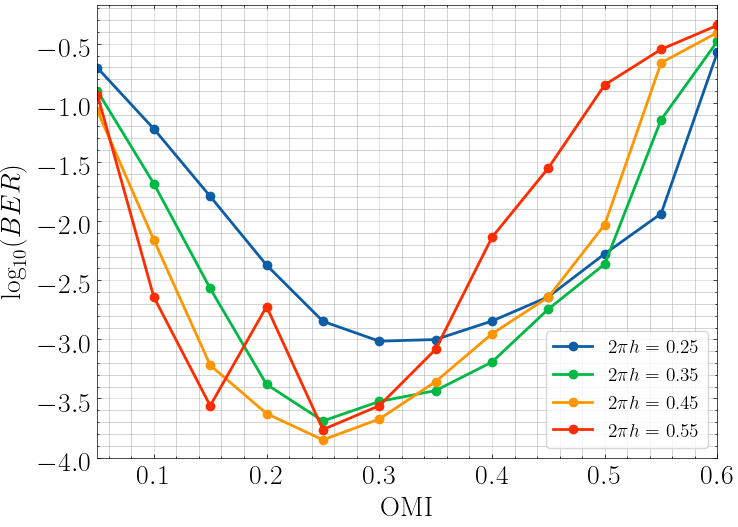

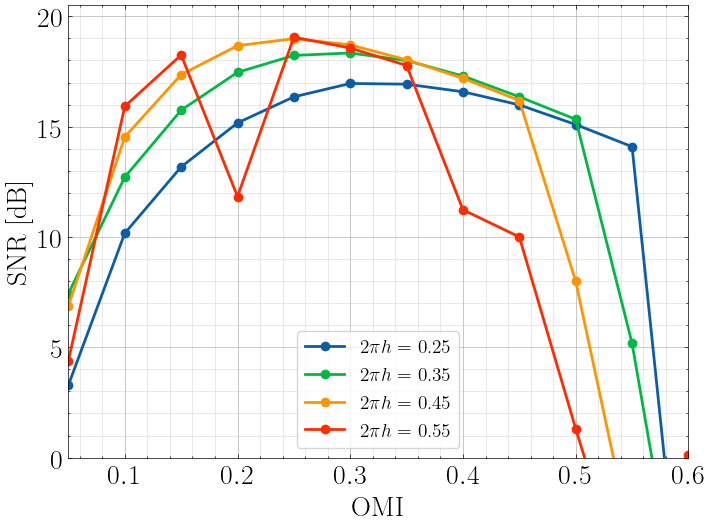

In [34]:
plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, np.log10(BER_CEDD_OMI[i,:]), '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-4)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.8)
plt.grid(which='major', alpha=1.5)

plt.figure(figsize = (8, 6))

for i in range(len(h)):
    plt.plot(OMI, SNR_CEDD_OMI[i,:], '-o', ms = 6, lw = 2, label = f'$2\pi h = $ {round(2*pi*h[i], 2)}')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=1)

## 1.2 - BER, SNR vs OMI, Vb - 1000 km de fibra - CE-DDO-OFDM

In [ ]:
OMI = np.arange(0.05, 0.61, 0.05)
A  = paramTx.Vπ*OMI*np.sqrt(2)
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H

Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ
paramTx.Pi_dBm = 2

BER_CEDD_Vb = np.zeros((len(Vb), len(A)))
SNR_CEDD_Vb = np.zeros((len(Vb), len(A)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [12]:
for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, AA in enumerate(A):
        paramTx.A = AA
        
        # Geração do sinal óptico
        sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
              
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # Filtro óptico pós-transmissor
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # Recepção óptica
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_CEDD_Vb[i, ind], _, SNR_CEDD_Vb[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')      

  0%|          | 0/3 [00:00<?, ?it/s]

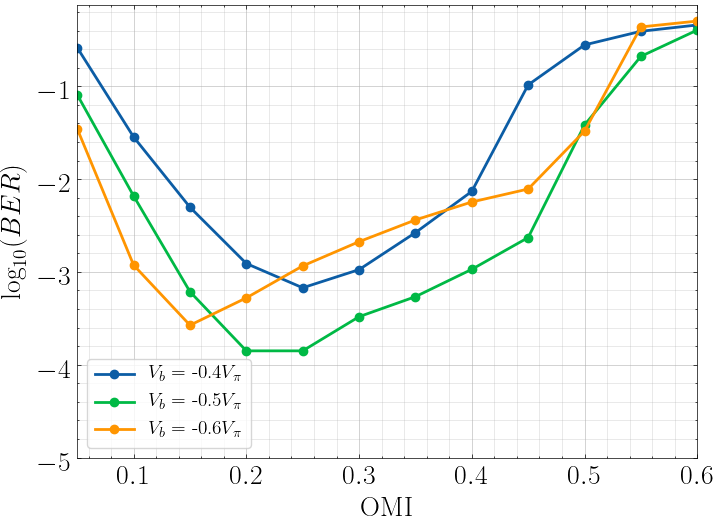

<Figure size 900x400 with 0 Axes>

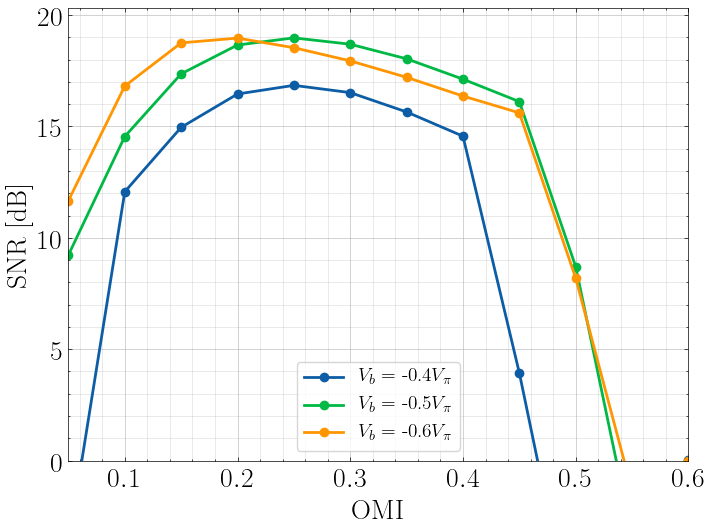

In [13]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_CEDD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_CEDD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

## 1.3 - BER, SNR vs OMI, Vb - 1000 km de fibra - DDO-OFDM

In [ ]:
g   = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
Vb  = np.array([-0.4, -0.5, -0.6])*paramTx.Vπ

OMI = np.zeros(len(g))

BER_DD_Vb = np.zeros((len(Vb), len(g)))
SNR_DD_Vb = np.zeros((len(Vb), len(g)))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [63]:
for i in tqdm(range(len(Vb))):
    paramTx.Vb = Vb[i]
    
    for ind, gg in enumerate(g):
        paramTx.g = gg
        
        sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
        
        if(i == 0):
            OMI[ind] = np.sqrt(np.mean((sigTx_DD)**2))/paramTx.Vπ
    
        sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
        snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
        sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
        # Filtro óptico pós-transmissor
        sigTxo = firFilter(filtro_optico_Tx, sigTxo)
        
        sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
        
        # Recepção óptica
        sigRxo = firFilter(filtro_optico_DD, sigRxo)
        ipd = photodiode(sigRxo, paramPD)
        
        # Demodulação dos símbolos
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        BER_DD_Vb[i, ind], _, SNR_DD_Vb[i, ind] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')   

  0%|          | 0/3 [00:00<?, ?it/s]

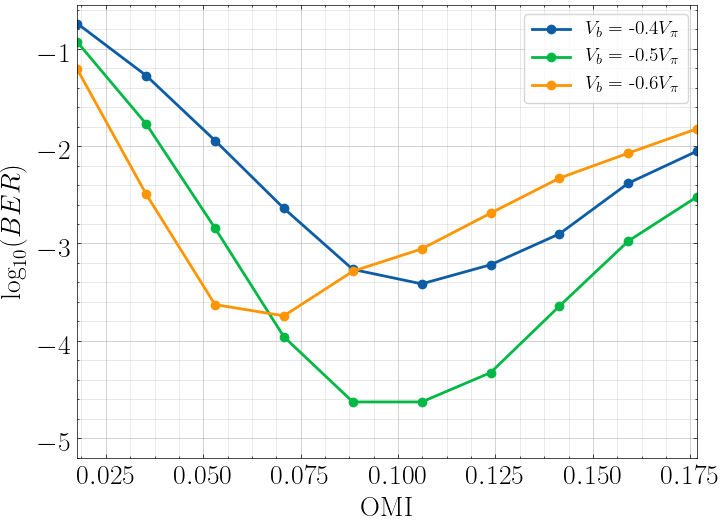

<Figure size 900x400 with 0 Axes>

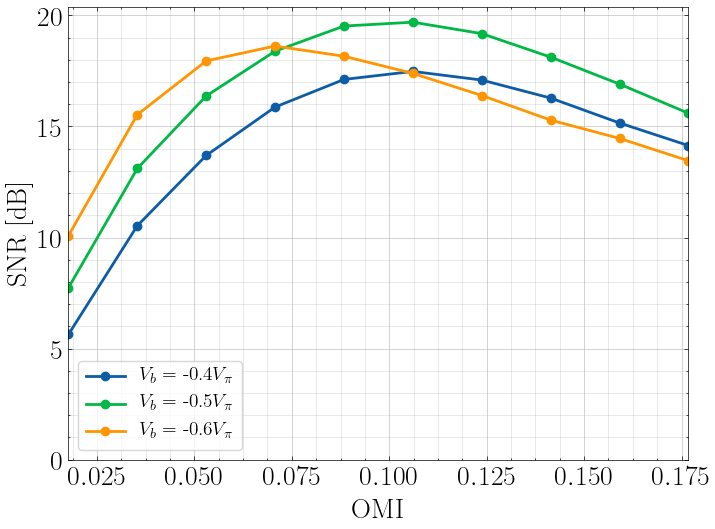

In [66]:
# BER vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, np.log10(BER_DD_Vb[i,:]), '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5.2)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)
plt.figure(figsize = (9, 4))

# SNR vs OMI - Vb
plt.figure(figsize = (8, 6))

for i in range(len(Vb)):
    plt.plot(OMI, SNR_DD_Vb[i,:], '-o', ms = 6, lw = 2, label = f'$V_b = $ {round(Vb[i]/paramTx.Vπ, 2)}$V_\pi$')

plt.xlabel(r"OMI")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(OMI), max(OMI))
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# 2 - Avaliação do efeito da potência óptica

In [ ]:
paramTx.A  = 1.15
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H

paramTx.Vb = -0.5*paramTx.Vπ
paramCh.Ltotal = 1000

osnrTx = 30
Pi = np.arange(-5, 12.5)

BER_CEDD_Pi = np.zeros(len(Pi))
SNR_CEDD_Pi = np.zeros(len(Pi))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [12]:
for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
    
    # Geração do sinal óptico
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
        
    # Filtro óptico pós-transmissor
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    
    # Recepção óptica
    sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
    ipd = photodiode(sigRxo, paramPD)
    
    # Demodulação dos símbolos
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
    
    BER_CEDD_Pi[i], _, SNR_CEDD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')    

  0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
paramTx.g  = 0.45
paramTx.Vb = -0.5*paramTx.Vπ

BER_DD_Pi = np.zeros(len(Pi))
SNR_DD_Pi = np.zeros(len(Pi))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [13]:
for i in tqdm(range(len(Pi))):
    paramTx.Pi_dBm = Pi[i]
        
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
        
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # Filtro óptico pós-transmissor
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo,_  = ssfm(sigTxo, paramTx.Fa, paramCh)
    
    # Recepção óptica
    sigRxo = firFilter(filtro_optico_DD, sigRxo)
    ipd = photodiode(sigRxo, paramPD)
        
    # Demodulação dos símbolos
    symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
    
    BER_DD_Pi[i], _, SNR_DD_Pi[i] = fastBERcalc(symbRx, symbTx, paramTx.M, 'qam')   

  0%|          | 0/18 [00:00<?, ?it/s]

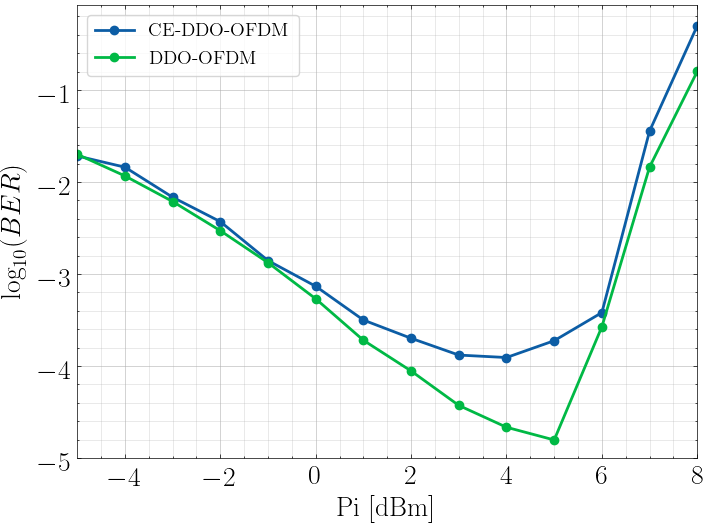

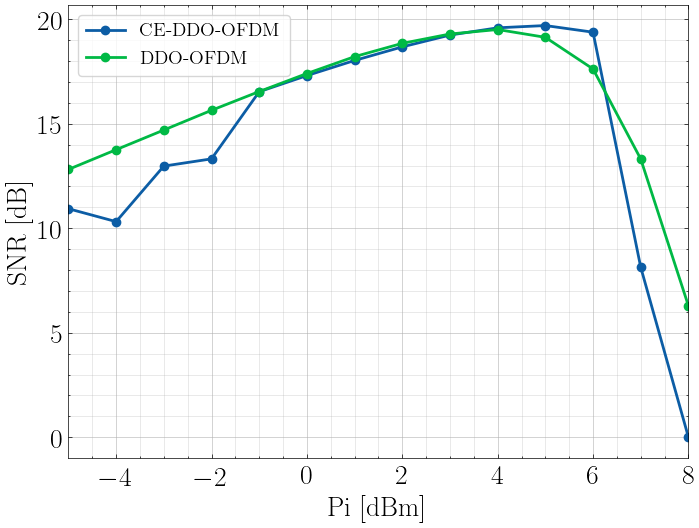

In [65]:
# BER vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, np.log10(BER_CEDD_Pi), '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, np.log10(BER_DD_Pi), '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"$\log_{10}(BER)$")
plt.ylim(-5)
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), 8)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# SNR vs Pi
plt.figure(figsize = (8, 6))

plt.plot(Pi, SNR_CEDD_Pi, '-o', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Pi, SNR_DD_Pi, '-o', ms = 6, lw = 2, label = "DDO-OFDM")

plt.xlabel(r"Pi [dBm]")
plt.ylabel(r"SNR [dB]")
plt.legend(fontsize = 14, frameon = True)
plt.xlim(min(Pi), 8)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

# 3 - Avaliação da influência da dispersão

In [ ]:
paramCh.Ltotal = 100
paramCh.gamma = 0

Nspan = np.arange(1, 30)
osnrTx = 30

Pi = np.array([2])
paramTx.H = 0.45/(2*pi)
paramRx.H = paramTx.H
paramTx.Vb = -0.5*paramTx.Vπ

BER_CEDD_L = np.zeros((len(Pi), len(Nspan)))
SNR_CEDD_L = np.zeros((len(Pi), len(Nspan)))

BER_CEDD_Leq = np.zeros((len(Pi), len(Nspan)))
SNR_CEDD_Leq = np.zeros((len(Pi), len(Nspan)))

paramTx.Scheme = "CE-DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [105]:
for i in range(len(Pi)):
    paramTx.Pi_dBm = Pi[i]
    
    sigTxo, sigTx, sigTx_CE, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # Filtro óptico pós-transmissor
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo = sigTxo.copy()
    sigRxo_eq = sigTxo.copy()

    for j in tqdm(range(len(Nspan))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        sigRxo = firFilter(filtro_optico_CEDD, sigRxo)
        
        # Sinal compensado
        sigRxo_eq,_ = ssfm(sigRxo_eq, paramTx.Fa, paramCh)
        sigRxo_eq = edc(sigRxo_eq, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)
        sigRxo_eq = firFilter(filtro_optico_CEDD, sigRxo_eq)
        
        ipd = photodiode(sigRxo, paramPD)
        ipd_eq = photodiode(sigRxo_eq, paramPD)
        
        # Resultados sem compensação de dispersão
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)

        discard = 100
        ind = np.arange(discard, len(symbRx)-discard)
        
        BER_CEDD_L[i,j], _, SNR_CEDD_L[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 
        
        # Resultados com compensação periódica de dispersão
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd_eq, pilot, pulse, t, paramRx)
        
        BER_CEDD_Leq[i,j], _, SNR_CEDD_Leq[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 

  0%|          | 0/29 [00:00<?, ?it/s]

In [ ]:
paramCh.Ltotal = 100

Pi = np.array([2])
paramTx.g = 0.45
paramTx.Vb = -0.5*paramTx.Vπ

BER_DD_L = np.zeros((len(Pi), len(Nspan)))
SNR_DD_L = np.zeros((len(Pi), len(Nspan)))

BER_DD_Leq = np.zeros((len(Pi), len(Nspan)))
SNR_DD_Leq = np.zeros((len(Pi), len(Nspan)))

paramTx.Scheme = "DDO-OFDM"
paramRx.Scheme = paramTx.Scheme

In [106]:
for i in range(len(Pi)):
    paramTx.Pi_dBm = Pi[i]
    
    sigTxo, sigTx, sigTx_DD, symbTx, t, pulse, pilot = Tx(paramTx)        
    sigTxo = np.sqrt(10**(paramTx.Pi_dBm/10)*1e-3) * sigTxo/np.sqrt(signal_power(sigTxo))
    
    snrTx = osnrTx - 10*np.log10(paramPD.B/(2*12.5e9))
    sigTxo = awgn(sigTxo, snrTx, paramTx.Fa, paramPD.B)
    
    # Filtro óptico pós-transmissor
    sigTxo = firFilter(filtro_optico_Tx, sigTxo)
    
    sigRxo = sigTxo.copy()
    sigRxo_eq = sigTxo.copy()
    
    for j in tqdm(range(len(Nspan))):
        sigRxo,_  = ssfm(sigRxo, paramTx.Fa, paramCh)
        sigRxo = firFilter(filtro_optico_DD, sigRxo)
        
        # Sinal compensado
        sigRxo_eq,_ = ssfm(sigRxo_eq, paramTx.Fa, paramCh)
        sigRxo_eq = edc(sigRxo_eq, paramCh.Ltotal, paramCh.D, paramTx.Fc, paramTx.Fa)
        sigRxo_eq = firFilter(filtro_optico_DD, sigRxo_eq)
        
        ipd = photodiode(sigRxo, paramPD)
        ipd_eq = photodiode(sigRxo_eq, paramPD)
        
        # Resultados sem compensação de dispersão
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd, pilot, pulse, t, paramRx)
        
        discard = 100
        ind = np.arange(discard, len(symbRx)-discard)
        
        BER_DD_L[i,j], _, SNR_DD_L[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 
        
        # Resultados com compensação periódica de dispersão
        symbRx, symbRx_neq, sigRx, H_abs, H_pha = Rx(ipd_eq, pilot, pulse, t, paramRx)
        
        BER_DD_Leq[i,j], _, SNR_DD_Leq[i,j] = fastBERcalc(symbRx[ind], symbTx[ind], paramTx.M, 'qam') 

  0%|          | 0/29 [00:00<?, ?it/s]

C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
C:\Users\embedded05\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


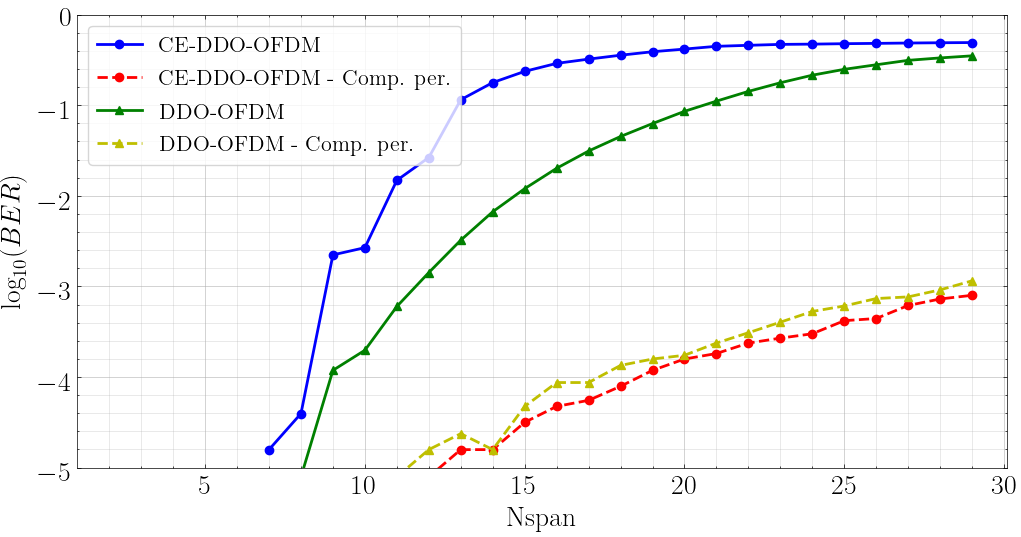

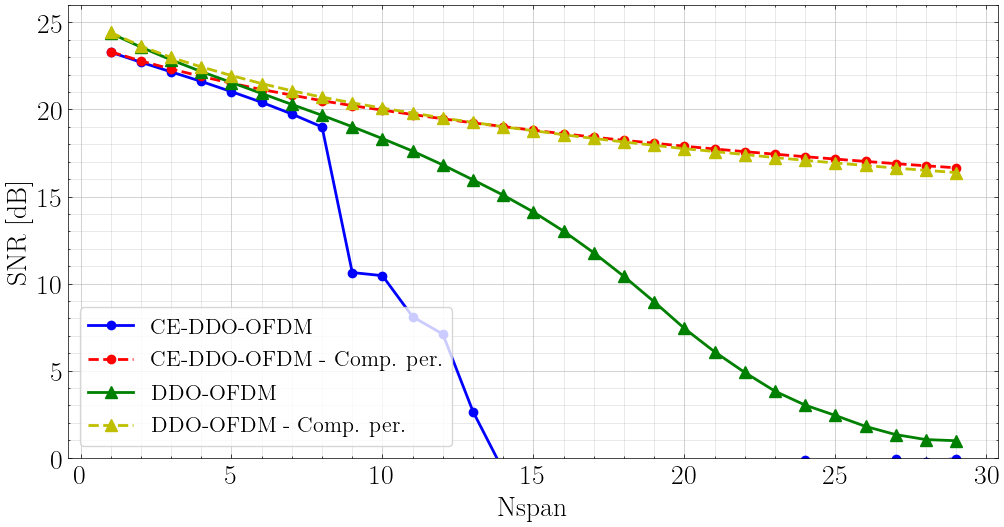

In [107]:
plt.figure(figsize = (12, 6))
plt.plot(Nspan, np.log10(BER_CEDD_L[0]), '-o', ms = 6, color = 'b', lw = 2, label = "CE-DDO-OFDM")
plt.plot(Nspan, np.log10(BER_CEDD_Leq[0,:]), '--o', ms = 6, color = 'r', lw = 2, label = "CE-DDO-OFDM - Comp. per.")
plt.plot(Nspan, np.log10(BER_DD_L[0]), '-^', ms = 6, color = 'g', lw = 2, label = "DDO-OFDM")
plt.plot(Nspan, np.log10(BER_DD_Leq[0,:]), '--^', ms = 6, color = 'y', lw = 2, label = "DDO-OFDM - Comp. per.")

plt.xlabel(r"Nspan")
plt.ylabel(r"$\log_{10}(BER)$")
plt.xlim(1)
plt.ylim(-5, 0)
plt.legend(fontsize = 16, frameon = True)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)

plt.figure(figsize = (12, 6))
plt.plot(Nspan, SNR_CEDD_L[0], '-o', color = 'b', ms = 6, lw = 2, label = "CE-DDO-OFDM")
plt.plot(Nspan, SNR_CEDD_Leq[0], '--o', color = 'r', ms = 6, lw = 2, label = "CE-DDO-OFDM - Comp. per.")
plt.plot(Nspan, SNR_DD_L[0], '-^', ms = 8, color = 'g', lw = 2, label = "DDO-OFDM")
plt.plot(Nspan, SNR_DD_Leq[0], '--^', ms = 8, color = 'y', lw = 2, label = "DDO-OFDM - Comp. per.")

plt.xlabel(r"Nspan")
plt.ylabel(r"SNR [dB]")
plt.ylim(0)
plt.legend(fontsize = 16, frameon = True)
plt.grid(which='minor', alpha=0.4)
plt.grid(which='major', alpha=0.8)